<a href="https://colab.research.google.com/github/shaifuss/data_science_seminar/blob/master/topic_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

import json
import pickle

import datetime
import time

!pip install pyspellchecker
!pip install sentence-transformers

workdir = r'/content/drive/My Drive/Data Science Class'
tmfile = r'tm.file'
processed_file = r'topic_data/processed_58993.pkl'
PERSIST_INTERVAL = 30 # in minutes

     |████████████████████████████████| 1.9MB 3.3MB/s 
     |████████████████████████████████| 71kB 2.4MB/s 
     |████████████████████████████████| 778kB 9.6MB/s 
     |████████████████████████████████| 890kB 42.9MB/s 
     |████████████████████████████████| 3.0MB 39.2MB/s 
     |████████████████████████████████| 1.1MB 42.1MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.3.0-cp36-none-any.whl size=86756 sha256=a6abf06a74855583db4f643b15a8b80dd0ef7f9769fd828224fad45051797006
  Stored in directory: /root/.cache/pip/wheels/b8/23/85/85d6a9a6c68f0625a1ecdaad903bb0a78df058c10cf74f9de4
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=1f531c755d9619b0706d0adb613b539a00ef58938912f544e6a5194d6c57173a
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sentence-transformers sacremoses


In this section we aim to identify distinct topics discussed in the corpus of pizza review texts. Once topics are identified, reviews that do not contain food-related topics can be filtered out. This has the potential to improve the image classification in the next stage by weeding out irrelevent samples - where reviewers didn't base their scores on the pizza. 

This will be achieved by building a topic model that categorizes the information present in each review. A topic can be modeled as a set of words that are all related. For instance, we might say that [noise, smell, music, dirt, lighting] reflects the topic of restaurant atmosphere.  

The first algorithm we will utilize is latent Dirichlet allocation. The premise of LDA (Biel et al., 2003) is that documents with similar topics use similar words. The algorithm aims to discover groups of words the occur frequently occur together in the same document. A topic is modeled as a probability distribution over words. Moreover, a document can be modeled as a probability distribution over different topics. 

Thus, the algorithm works as follows:

1.   Remove unimportant words and set how many topics to find.
2.   Randomly assign each word in each document to a random topic
3.   For each document,
>a. choose a topic, assuming all others are allocated correctly

>>i. calculate the topic distribution within the document:  p(topic | document)

>>ii. calculate the word distribution within the topic: p(word | topic)

>> iii. multiply i and ii together and assign words to new topics based on the result

4. terminate when there are no new assignments

The LDA model is finetuned by several parameters:
Alpha reflects how many topics are in a given document (higher values lead to more topics per document in the model)
Beta reflects how many words are in a given topic (higher values lead to more words per topic in the model). In this implementation, the model is set to learn these values automatically.

We compare the pure LDA model with a hybrid version that utilizes sentence embeddings of the review texts crafted by BERT (Devlin et al., 2018). Inspiration for this hybrid model comes from https://blog.insightdatascience.com/contextual-topic-identification-4291d256a032.

BERT is a pretrained language model from researchers at Google that utilizes a multiheaded transformer ANN architecture to craft word vectors that learns to capture the meaning of words from the context in which they are found. BERT and its successors have acheived impressive performance on language understatnding tasks like question answering and others. 

The hybrid model attempted here fuses the topic probability vector from LDA with the review text embedding from BERT to create a hybrid sample. Clustering is then performed to distinguish different topics in the corpus. The most frequent words in the cluster become the topic. 

 


In [ ]:
# loading reviews into dataframe and peak at the data
def load_reviews():
  with open(r'/content/drive/My Drive/Data Science Class/pizza_reviews.json', 'r') as f:
    pizza_reviews = json.load(f)
  return pizza_reviews
review_list = load_reviews()
print(len(review_list))
review_df = pd.DataFrame(review_list)

text_df = review_df[['review_id', 'text']].copy()
text_df.head()

479792


,review_id,text
0,mM8i91yWP1QbImEvz5ds0w,"In the heart of Chinatown, I discovered it enr..."
1,09qxjFi4abaW66JeSLazuQ,Was a Chicago style deep dish. Homemade type ...
2,K-wdPGHbErfxbKK6PetrmA,First time eating there and everything was so ...
3,jkVxX4ieJwVRO9n4E8tNMw,More than just Pizza. This location is small ...
4,Lb9r62Qlu12ZB909CbFeOQ,I ordered a pizza at 4:49. Got an email that s...


Preprocessing is necessary to create a universal vocabulary for the corpus. Each text is first processed at the string level and then at the word level. 

Examples:
1. fix typos and missing spaces
2. remove punctuation, capitalization, and numbers
3. remove unimportant words (stopwords)
4. stem words so that a fair comparison can be made (for example, salted and salty both become salt)

Due to constraints on time and computational resources, a sample of 58993 pizza reviews was used out of nearly 480000 in the dataset.

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import re

from spellchecker import SpellChecker

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def regex_filter(sentence):
    # fix missing delimiter - i.e deepDishPizza
    sentence = re.sub(r'([a-z])([A-Z])', r'\1\. \2', sentence)
    sentence = sentence.lower()
    sentence = re.sub(r'&gt|&lt', ' ', sentence)
    # fix letter repetition (if more than 2)
    sentence = re.sub(r'([a-z])\1{2,}', r'\1', sentence)
    # fix non-word repetition (if more than 1)
    sentence = re.sub(r'([\W+])\1{1,}', r'\1', sentence)
    # string * as delimiter
    sentence = re.sub(r'\*|\W\*|\*\W', '. ', sentence)
    # xxx[?!]. -- > xxx.
    sentence = re.sub(r'\W+?\.', '.', sentence)
    # [.?!] --> [.?!] xxx
    sentence = re.sub(r'(\.|\?|!)(\w)', r'\1 \2', sentence)
    # fix phrase repetition
    sentence = re.sub(r'(.{2,}?)\1{1,}', r'\1', sentence)

    return sentence.strip()

In [ ]:
# remove numbers and punctuation marks
def filter_punctuation(word_list):
    return [word for word in word_list if word.isalpha()]

# remove unimportant connective words such as "and", "the", etc
def filter_stopwords(word_list):
  return [word for word in word_list if word not in stopwords.words('english')]

# keep only nouns
def retain_nouns(word_list):
    return [word for (word, pos) in nltk.pos_tag(word_list) if pos[:2] in ['NN']] #, 'VBP', 'VBN']]

# normlize for part of speech
def stem_words(word_list):
  ps = PorterStemmer()
  return [ps.stem(word) for word in word_list]

def fix_spelling(word_list):
  spell = SpellChecker()
  return [spell.correction(word) for word in word_list]

In [ ]:
def preprocess_words(text):
  word_list = word_tokenize(text)
  word_list = filter_punctuation(word_list)
  word_list = fix_spelling(word_list) 
  word_list = filter_stopwords(word_list)
  word_list = retain_nouns(word_list)
  return stem_words(word_list)

In [ ]:
def persist_processed_data(texts, token_lists, idx_in):
  print("Saving at {}".format(time.time()))
  with open(os.path.join(workdir, processed_file), 'wb') as p:
          pickle.dump([texts, token_lists, idx_in], p)   

In [ ]:
def preprocess(reviews, samp_size=None):
  if not samp_size:
        samp_size = 1000

  start = time.time()
  print('Stage 1: Preprocess raw review texts')
  texts = []  
  token_lists = []  
  idx_in = []
  batch_start = time.time()
  indicies = np.random.choice(len(reviews), samp_size)
  for i in indicies:
      text = regex_filter(reviews[i])
      token_list = preprocess_words(text)
      if token_list:
        idx_in.append(i)
        texts.append(text)
        token_lists.append(token_list)
      batch_end = time.time() 
      if ((batch_end - batch_start)/60) > PERSIST_INTERVAL:
        batch_start = batch_end
        persist_processed_data(texts, token_lists, idx_in)
           
  end = time.time()
  print("Preprocessing {} reviews took {} minutes".format(len(indicies), str((end - start)/60)))
  persist_processed_data(texts, token_lists, idx_in)
  return texts, token_lists, idx_in
  

For the hybrid model, BERT outputs sentence-level encodings of length 768 (the first output vector corresponding to the CLS token passed in at the start of each text). An LDA vector contains a probability value in range [0.0, 1.0] for each possible topic. The LDA and BERT outputs are concatenated together and clustering is performed on the resulting high-dimension vectors (the default algorithm used here is KMeans). Concatenization is parametrized by gamma, the factor to scale the LDA vectors so as to increase their relative importance. 

In an attempt to improve the clustering, dimensionality reduction is performed. An autoencoder is trained on the LDA+BERT vectors. Once training is complete, the middle hidden layer of length 32 is taken as a representation of the original data. This achieves compression of at least 25x. 

Clustering is performed on the compressed vectors. After clustering, topics are constructed from the top 5 most frequent words in each cluster.

In [2]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')


class Autoencoder:
    """
    Autoencoder for learning latent space representation
    architecture simplified for only one hidden layer
    """

    def __init__(self, latent_dim=32, activation='relu', epochs=200, batch_size=128):
        self.latent_dim = latent_dim
        self.activation = activation
        self.epochs = epochs
        self.batch_size = batch_size
        self.autoencoder = None
        self.encoder = None
        self.decoder = None
        self.his = None

    def _compile(self, input_dim):
        """
        compile the computational graph
        """
        input_vec = Input(shape=(input_dim,))
        encoded = Dense(self.latent_dim, activation=self.activation)(input_vec)
        decoded = Dense(input_dim, activation=self.activation)(encoded)
        self.autoencoder = Model(input_vec, decoded)
        self.encoder = Model(input_vec, encoded)
        encoded_input = Input(shape=(self.latent_dim,))
        decoder_layer = self.autoencoder.layers[-1]
        self.decoder = Model(encoded_input, self.autoencoder.layers[-1](encoded_input))
        self.autoencoder.compile(optimizer='adam', loss=keras.losses.mean_squared_error)

    def fit(self, X):
        if not self.autoencoder:
            self._compile(X.shape[1])
        X_train, X_test = train_test_split(X)
        self.his = self.autoencoder.fit(X_train, X_train,
                                        epochs=200,
                                        batch_size=128,
                                        shuffle=True,
                                        validation_data=(X_test, X_test), verbose=0)

Using TensorFlow backend.


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from gensim import corpora
import gensim

# define model object
class Topic_Model:
    def __init__(self, k=4, method='LDA_BERT'):
        """
        :param k: number of topics
        :param method: method chosen for the topic model
        """
        if method not in {'LDA', 'BERT', 'LDA_BERT'}:
            raise Exception('Invalid method!')
        self.k = k
        self.dictionary = None
        self.corpus = None
        self.cluster_model = None
        self.ldamodel = None
        self.vec = {}
        self.gamma = 90  # parameter for reletive importance of lda
        self.method = method
        self.AE = None
        self.id = method + '_' + str(time.time())

    def vectorize(self, sentences, token_lists, method=None):
        """
        Get vector representations from selected methods
        """
        # Default method
        if method is None:
            method = self.method

        # turn tokenized documents into a id <-> term dictionary
        self.dictionary = corpora.Dictionary(token_lists)
        # convert tokenized documents into a document-term matrix
        self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        if method == 'LDA':
            print('Getting vector representations for LDA ...')
            if not self.ldamodel:
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary,
                                                                passes=20, alpha='auto', )

            def get_vec_lda(model, corpus, k):
                """
                Get the LDA vector representation (probabilistic topic assignments for all documents)
                :return: vec_lda with dimension: (n_doc * n_topic)
                """
                n_doc = len(corpus)
                vec_lda = np.zeros((n_doc, k))
                for i in range(n_doc):
                    # get the distribution for the i-th document in corpus
                    for topic, prob in model.get_document_topics(corpus[i]):
                        vec_lda[i, topic] = prob

                return vec_lda

            vec = get_vec_lda(self.ldamodel, self.corpus, self.k)
            print('Finished getting vector representations for LDA')
            return vec

        elif method == 'BERT':

            print('Getting vector representations for BERT ...')
            from sentence_transformers import SentenceTransformer
            model = SentenceTransformer('bert-base-nli-max-tokens')
            vec = np.array(model.encode(sentences, show_progress_bar=True))
            print('Finished getting vector representations for BERT')
            return vec

        #         elif method == 'LDA_BERT':
        else: 
            vec_lda = self.vectorize(sentences, token_lists, method='LDA')
            vec_bert = self.vectorize(sentences, token_lists, method='BERT')
            vec_ldabert = np.c_[vec_lda * self.gamma, vec_bert]
            self.vec['LDA_BERT_FULL'] = vec_ldabert
            if not self.AE:
                self.AE = Autoencoder()
                print('Fitting Autoencoder ...')
                self.AE.fit(vec_ldabert)
                print('Fitting Autoencoder Done!')
            vec = self.AE.encoder.predict(vec_ldabert)
            return vec

    def fit(self, sentences, token_lists, method=None, m_clustering=None):
        """
        Fit the topic model for selected method given the preprocessed data
        :docs: list of documents, each doc is preprocessed as tokens
        :return:
        """
        # Default method
        if method is None:
            method = self.method
        # Default clustering method
        if m_clustering is None:
            m_clustering = KMeans

        # turn tokenized documents into a id <-> term dictionary
        if not self.dictionary:
            self.dictionary = corpora.Dictionary(token_lists)
            # convert tokenized documents into a document-term matrix
            self.corpus = [self.dictionary.doc2bow(text) for text in token_lists]

        ####################################################
        #### Getting ldamodel or vector representations ####
        ####################################################

        if method == 'LDA':
            if not self.ldamodel:
                print('Fitting LDA ...')
                self.ldamodel = gensim.models.ldamodel.LdaModel(self.corpus, num_topics=self.k, id2word=self.dictionary
                                                                , alpha='auto', eta='auto', minimum_probability=0.3)
                print('Fitting LDA Done!')
        else:
            print('Clustering embeddings ...')
            self.cluster_model = m_clustering(self.k)
            self.vec[method] = self.vectorize(sentences, token_lists, method)
            self.cluster_model.fit(self.vec[method])
            print('Clustering embeddings. Done!')

    def predict(self, sentences, token_lists, out_of_sample=None):
        """
        Predict topics for new_documents
        """
        # Default as False
        out_of_sample = out_of_sample is not None

        if out_of_sample:
            corpus = [self.dictionary.doc2bow(text) for text in token_lists]
            if self.method != 'LDA':
                vec = self.vectorize(sentences, token_lists)
                print(vec)
        else:
            corpus = self.corpus
            vec = self.vec.get(self.method, None)

        if self.method == "LDA":
            lbs = np.array(list(map(lambda x: sorted(self.ldamodel.get_document_topics(x),
                                                     key=lambda x: x[1], reverse=True)[0][0],
                                    corpus)))
        else:
            lbs = self.cluster_model.predict(vec)
        return lbs

For interpretation, the coherence and silhoutte score of the clustering is computed. 

In [4]:
from collections import Counter
from sklearn.metrics import silhouette_score
import umap
import matplotlib.pyplot as plt
from gensim.models.coherencemodel import CoherenceModel
import os


def get_topic_words(token_lists, labels, k=None):
    """
    get top words within each topic from clustering results
    """
    if k is None:
        k = len(np.unique(labels))
    topics = ['' for _ in range(k)]
    for i, c in enumerate(token_lists):
        topics[labels[i]] += (' ' + ' '.join(c))
    word_counts = list(map(lambda x: Counter(x.split()).items(), topics))
    # get sorted word counts
    word_counts = list(map(lambda x: sorted(x, key=lambda x: x[1], reverse=True), word_counts))
    # get topics
    topics = list(map(lambda x: list(map(lambda x: x[0], x[:5])), word_counts))
    print("Topics are:\n{}".format(topics))
    return topics

def get_coherence(model, token_lists, measure='c_v'):
    """
    Get model coherence from gensim.models.coherencemodel
    :param model: Topic_Model object
    :param token_lists: token lists of docs
    :param topics: topics as top words
    :param measure: coherence metrics
    :return: coherence score
    """
    if model.method == 'LDA':
        cm = CoherenceModel(model=model.ldamodel, texts=token_lists, corpus=model.corpus, dictionary=model.dictionary,
                            coherence=measure)
        print(CoherenceModel.top_topics_as_word_lists(model=model.ldamodel, dictionary=model.dictionary, topn=5))
    else:
        topics = get_topic_words(token_lists, model.cluster_model.labels_)
        cm = CoherenceModel(topics=topics, texts=token_lists, corpus=model.corpus, dictionary=model.dictionary,
                            coherence=measure)
    return cm.get_coherence()

def get_silhouette(model):
    """
    Get silhouette score from model
    :param model: Topic_Model object
    :return: silhouette score
    """
    if model.method == 'LDA':
        return
    lbs = model.cluster_model.labels_
    vec = model.vec[model.method]
    return silhouette_score(vec, lbs)

def plot_proj(embedding, lbs):
    """
    Plot UMAP embeddings
    :param embedding: UMAP (or other) embeddings
    :param lbs: labels
    """
    n = len(embedding)
    counter = Counter(lbs)
    for i in range(len(np.unique(lbs))):
        plt.plot(embedding[:, 0][lbs == i], embedding[:, 1][lbs == i], '.', alpha=0.5,
                 label='cluster {}: {:.2f}%'.format(i, counter[i] / n * 100))
    plt.legend(loc = 'best')
    plt.grid(color ='grey', linestyle='-',linewidth = 0.25)

In [5]:
outdir = r'/content/drive/My Drive/Data Science Class/viz'

def visualize(model):
    """
    Visualize the result for the topic model by 2D embedding (UMAP)
    :param model: Topic_Model object
    """
    if model.method == 'LDA':
        return
    reducer = umap.UMAP()
    print('Calculating UMAP projection ...')
    vec_umap = reducer.fit_transform(model.vec[model.method])
    print('Calculating UMAP projection. Done!')
    plot_proj(vec_umap, model.cluster_model.labels_)
    plt.savefig(outdir + '/{}_{}.jpeg'.format(model.method, model.id), format='jpeg')

In [ ]:
samp_size = 500
data = text_df
data = data.fillna('')  # only the comments has NaN's
reviews = data.text
sentences, token_lists, idx_in = preprocess(reviews, samp_size=samp_size)
#with open(os.path.join(workdir, processed_file), 'wb') as p:
#  pickle.dump([sentences, token_lists, idx_in], p)

Our original assumtion was to set the number of topics to 4, reflecting the following topics:

1. Food
2. Service
3. Atmosphere
4. Value

After mulitple runs, the results were better with 3 topics.


In [12]:

def train(method):
    
  processed_file = r'topic_data/processed_58933.pkl'
  tmfile =  method + "_" + str(time.time()) +'.file'
  #method = "LDA_BERT"
  ntopic = 4
  
  with open(os.path.join(workdir, processed_file), 'rb') as p:
    sentences, token_lists, idx_in = pickle.load(p)

  print("Starting training")
  start = time.time()
  tm = Topic_Model(k = ntopic)
  tm.fit(sentences, token_lists)
  end = time.time()
  print("Training on {} reviews took {} minutes".format(len(sentences), str((end - start)/60)))
  with open(os.path.join(workdir, tmfile, 'wb') as f:
    pickle.dump(tm, f, pickle.HIGHEST_PROTOCOL)
  
  # coherence measures internal consistency of a topic
  print('Coherence:', get_coherence(tm, token_lists, 'c_v'))
  # silhoutte measures consistency of clusters
  print('Silhouette Score:', get_silhouette(tm))
  # visualize and save img
  visualize(tm)


Coherence is used for topic moodel evaluation (Roder et al., 2015). As topic models produced algorithmically are sometimes not easily interpreted by humans, it is necessary to have a way to objectively measure how well the words in a topic go together. In general, coherence can be evaluated for a topic by using a Cartesian product on itself to construct pairs (excluding twin pairs). The co-occurence of each pair is checked in an external reference - a very large corpus of texts said to represent common language usage. The higher the co-occurence scores, the higher the topic coherence.

A silhoutte score is used to evaluate clustering. 

Starting training
Clustering embeddings ...
Getting vector representations for LDA ...
Finished getting vector representations for LDA
Getting vector representations for BERT ...



Finished getting vector representations for BERT
Fitting Autoencoder ...
Fitting Autoencoder Done!
Clustering embeddings. Done!
Training on 58933 reviews took 28.03458616336187 minutes
Topics are:
[['pizza', 'place', 'crust', 'order', 'slice'], ['pizza', 'place', 'food', 'time', 'servic'], ['food', 'place', 'servic', 'time', 'order'], ['food', 'pizza', 'place', 'time', 'servic']]
Coherence: 0.48393876718207685
Silhouette Score: 0.29959032
Calculating UMAP projection ...
Calculating UMAP projection. Done!


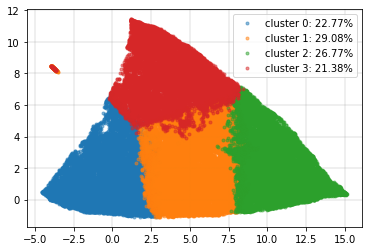

In [13]:
train('LDA_BERT')

In [ ]:
train('LDA')

Evaluation

We compare the hybrid topic cluster model with a pure LDA model. The models were run multiple times with a range of values for each hyperparameter.

Observations:
1. Coherence was consistently an order of magnitude higher for the pure LDA model. 
2. Silhoutte scores improved as the LDA vectors were weighted more heavily in the hybrid model
3. The pure LDA model produced higher quality topics as judged by two human evaluators (us). 



For prediction with the pure LDA model, the topics are retrieved for a given review. If the pizza topic does not have a high score, our hypothesis is that discarding it will lead to improved performance for the image classifier.

For prediction with the LDA+BERT version, a review is place into a cluster with the pretrained model. Similar to the pure model, reviews that are found to belong to a cluster (i.e topic) that doesn't put a strong emphasis on pizza should be discarded. 

In [ ]:
workdir = r'/content/drive/My Drive/Data Science Class'
import os
import pickle
with open(os.path.join(workdir, r'topic_data/processed_max.pkl'), 'rb') as p:
    sentences, token_lists, idx_in = pickle.load(p)

print(len(sentences))

36228
